# Explorative Cluster-Analyse der Gleisbilder

Diese Notebook führt eine unüberwachte Cluster-Analyse der Center-Bilder durch, um ohne Vorwissen Strukturen und Muster in den Daten zu entdecken.

**Ziele:**
- Feature-Extraktion mit vortrainiertem CNN (ResNet50)
- K-Means und DBSCAN Clustering
- Evaluierung der Cluster-Qualität
- Visualisierung und Interpretation der Ergebnisse

**Erwartete Erkenntnisse:**
- Unterschiedliche Untergrundtypen (Schotter vs. Asphalt)
- Verschiedene Beleuchtungsbedingungen
- Stadtspezifische Unterschiede
- Anomalien oder seltene Situationen

In [3]:
# Import Required Libraries
import os
import shutil
# Force TensorFlow to use CPU only - MUST BE SET BEFORE IMPORTING TENSORFLOW
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from collections import Counter, defaultdict

# Machine Learning Libraries
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, normalize

# Deep Learning Libraries - Import AFTER setting environment variables
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Image Processing
from PIL import Image
import cv2

# Visualization
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#print(f"TensorFlow version: {tf.__version__}")
#print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
#print(f"Running on CPU only")

In [4]:
# Configuration
DATASET_PATH = "./datasets/clustering_sample_10000"  # Path to sampled dataset
RESULTS_PATH = "./results/clustering_analysis"      # Output path for results
BATCH_SIZE = 32                                     # Batch size for feature extraction
IMG_SIZE = (224, 224)                              # Input size for ResNet50
FEATURE_DIM = 2048                                 # ResNet50 feature dimension
N_CLUSTERS_RANGE = range(3, 16)                    # Range of k values to test
PCA_COMPONENTS = 50                                # PCA components for dimensionality reduction
RANDOM_STATE = 42                                  # Random state for reproducibility

In [5]:
# Create results directory
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

print(f"Dataset path: {DATASET_PATH}")
print(f"Results path: {RESULTS_PATH}")

# Check if dataset exists
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path {DATASET_PATH} does not exist!")
    print("Available dataset directories:")
    datasets_dir = Path("./datasets")
    if datasets_dir.exists():
        for subdir in datasets_dir.iterdir():
            if subdir.is_dir():
                img_count = len([f for f in subdir.iterdir() if f.suffix == '.png'])
                print(f"  {subdir.name}: {img_count} images")
else:
    img_count = len([f for f in Path(DATASET_PATH).iterdir() if f.suffix == '.png'])
    print(f"Found {img_count} images in dataset")

Dataset path: ./datasets/clustering_sample_10000
Results path: ./results/clustering_analysis
Found 6089 images in dataset


In [6]:
def parse_filename(filename: str):
    """Parse filename to extract tenant, SID, and original filename."""
    if not filename.endswith('_C.png'):
        return None, None, None
    
    name_without_ext = filename[:-6]  # Remove '_C.png'
    parts = name_without_ext.split('_')
    
    if len(parts) >= 3:
        tenant = parts[0]
        sid = parts[1]
        original_filename = '_'.join(parts[2:])
        return tenant, sid, original_filename
    
    return None, None, None

def load_dataset_info(dataset_path: str):
    """Load and analyze dataset information."""
    image_files = []
    tenant_distribution = defaultdict(int)
    
    for file_path in Path(dataset_path).glob('*_C.png'):
        filename = file_path.name
        tenant, sid, original_name = parse_filename(filename)
        
        if tenant:
            image_files.append({
                'filepath': str(file_path),
                'filename': filename,
                'tenant': tenant,
                'sid': sid,
                'original_name': original_name
            })
            tenant_distribution[tenant] += 1
    
    return image_files, dict(tenant_distribution)

# Load dataset information
print("Loading dataset information...")
image_files, tenant_distribution = load_dataset_info(DATASET_PATH)

print(f"\nTotal images: {len(image_files)}")
print(f"Number of tenants: {len(tenant_distribution)}")
print("\nTenant distribution:")
for tenant, count in sorted(tenant_distribution.items()):
    percentage = (count / len(image_files)) * 100
    print(f"  {tenant}: {count} images ({percentage:.1f}%)")

Loading dataset information...

Total images: 6089
Number of tenants: 8

Tenant distribution:
  ava: 760 images (12.5%)
  bernmobil: 750 images (12.3%)
  bvb: 759 images (12.5%)
  cts: 748 images (12.3%)
  gent: 744 images (12.2%)
  gvb: 785 images (12.9%)
  retm: 782 images (12.8%)
  vbz: 761 images (12.5%)


In [7]:
def load_and_preprocess_image(image_path: str, target_size: tuple = IMG_SIZE):
    """Load and preprocess image for ResNet50."""
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def create_feature_extractor():
    """Create ResNet50 feature extractor (without top classification layer)."""
    print("Loading ResNet50 model...")
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'  # Global average pooling
    )
    
    # The model output will be (batch_size, 2048) features
    print(f"Feature extractor output shape: {base_model.output_shape}")
    return base_model

def extract_features_batch(model, image_paths: list, batch_size: int = BATCH_SIZE):
    """Extract features from images in batches."""
    features = []
    valid_paths = []
    
    print(f"Extracting features from {len(image_paths)} images...")
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_valid_paths = []
        
        # Load batch images
        for img_path in batch_paths:
            img_array = load_and_preprocess_image(img_path)
            if img_array is not None:
                batch_images.append(img_array[0])  # Remove batch dimension
                batch_valid_paths.append(img_path)
        
        if batch_images:
            # Convert to numpy array and predict
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images, verbose=0)
            
            features.extend(batch_features)
            valid_paths.extend(batch_valid_paths)
        
        # Progress update
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {min(i + batch_size, len(image_paths))}/{len(image_paths)} images")
    
    return np.array(features), valid_paths

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Extract features using ResNet50
print("=" * 80)
print("FEATURE EXTRACTION")
print("=" * 80)

# Create feature extractor
feature_extractor = create_feature_extractor()

# Extract image paths
image_paths = [item['filepath'] for item in image_files]

# Extract features
start_time = time.time()
features, valid_paths = extract_features_batch(feature_extractor, image_paths)
extraction_time = time.time() - start_time

print(f"\nFeature extraction completed in {extraction_time:.2f} seconds")
print(f"Extracted features shape: {features.shape}")
print(f"Valid images: {len(valid_paths)}/{len(image_paths)}")

# Update image_files to only include valid images
valid_image_files = []
for img_file in image_files:
    if img_file['filepath'] in valid_paths:
        valid_image_files.append(img_file)

image_files = valid_image_files
print(f"Updated image files: {len(image_files)}")

FEATURE EXTRACTION
Loading ResNet50 model...
Feature extractor output shape: (None, 2048)
Extracting features from 6089 images...
  Processed 320/6089 images
  Processed 640/6089 images
  Processed 960/6089 images
  Processed 1280/6089 images
  Processed 1600/6089 images
  Processed 1920/6089 images
  Processed 2240/6089 images
  Processed 2560/6089 images
  Processed 2880/6089 images
  Processed 3200/6089 images
  Processed 3520/6089 images
  Processed 3840/6089 images
  Processed 4160/6089 images
  Processed 4480/6089 images
  Processed 4800/6089 images
  Processed 5120/6089 images
  Processed 5440/6089 images
  Processed 5760/6089 images
  Processed 6080/6089 images

Feature extraction completed in 237.21 seconds
Extracted features shape: (6089, 2048)
Valid images: 6089/6089
Updated image files: 6089


In [9]:
# Normalize features
print("Normalizing features...")
features_normalized = normalize(features, norm='l2', axis=1)

print(f"Original feature statistics:")
print(f"  Mean: {features.mean():.4f}")
print(f"  Std: {features.std():.4f}")
print(f"  Min: {features.min():.4f}")
print(f"  Max: {features.max():.4f}")

print(f"\nNormalized feature statistics:")
print(f"  Mean: {features_normalized.mean():.4f}")
print(f"  Std: {features_normalized.std():.4f}")
print(f"  L2 norm (first sample): {np.linalg.norm(features_normalized[0]):.4f}")

# Optional: Apply PCA for dimensionality reduction
print(f"\nApplying PCA to reduce dimensions from {FEATURE_DIM} to {PCA_COMPONENTS}...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
features_pca = pca.fit_transform(features_normalized)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"PCA features shape: {features_pca.shape}")

# We'll use both normalized full features and PCA features for comparison
features_for_clustering = features_normalized  # Start with full features

Normalizing features...
Original feature statistics:
  Mean: 0.2476
  Std: 0.8855
  Min: 0.0000
  Max: 22.0868

Normalized feature statistics:
  Mean: 0.0059
  Std: 0.0213
  L2 norm (first sample): 1.0000

Applying PCA to reduce dimensions from 2048 to 50...
PCA explained variance ratio: 0.9151
PCA features shape: (6089, 50)


In [10]:
def evaluate_kmeans_clusters(features, k_range, use_minibatch=True):
    """Evaluate K-Means clustering for different k values."""
    results = []
    
    print(f"Evaluating K-Means for k in {list(k_range)}...")
    
    for k in k_range:
        print(f"  Testing k={k}...")
        
        # Use MiniBatchKMeans for efficiency with large datasets
        if use_minibatch:
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                random_state=RANDOM_STATE,
                batch_size=100,
                n_init=10
            )
        else:
            kmeans = KMeans(
                n_clusters=k,
                random_state=RANDOM_STATE,
                n_init=10
            )
        
        # Fit and predict
        cluster_labels = kmeans.fit_predict(features)
        
        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(features, cluster_labels)
        
        # Cluster sizes
        cluster_sizes = Counter(cluster_labels)
        min_cluster_size = min(cluster_sizes.values())
        max_cluster_size = max(cluster_sizes.values())
        
        results.append({
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'min_cluster_size': min_cluster_size,
            'max_cluster_size': max_cluster_size,
            'cluster_sizes': dict(cluster_sizes),
            'model': kmeans
        })
        
        print(f"    Inertia: {inertia:.2f}, Silhouette: {silhouette_avg:.4f}")
    
    return results

# Evaluate K-Means clustering
print("=" * 80)
print("K-MEANS CLUSTERING EVALUATION")
print("=" * 80)

kmeans_results = evaluate_kmeans_clusters(features_for_clustering, N_CLUSTERS_RANGE)

K-MEANS CLUSTERING EVALUATION
Evaluating K-Means for k in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]...
  Testing k=3...
    Inertia: 1133.10, Silhouette: 0.3626
  Testing k=4...
    Inertia: 1033.12, Silhouette: 0.3609
  Testing k=5...
    Inertia: 898.99, Silhouette: 0.3797
  Testing k=6...
    Inertia: 842.68, Silhouette: 0.3471
  Testing k=7...
    Inertia: 810.40, Silhouette: 0.3718
  Testing k=8...
    Inertia: 764.85, Silhouette: 0.3515
  Testing k=9...
    Inertia: 720.55, Silhouette: 0.3422
  Testing k=10...
    Inertia: 714.86, Silhouette: 0.3232
  Testing k=11...
    Inertia: 687.89, Silhouette: 0.3245
  Testing k=12...
    Inertia: 685.11, Silhouette: 0.3120
  Testing k=13...
    Inertia: 672.39, Silhouette: 0.3126
  Testing k=14...
    Inertia: 641.18, Silhouette: 0.2887
  Testing k=15...
    Inertia: 634.66, Silhouette: 0.2790


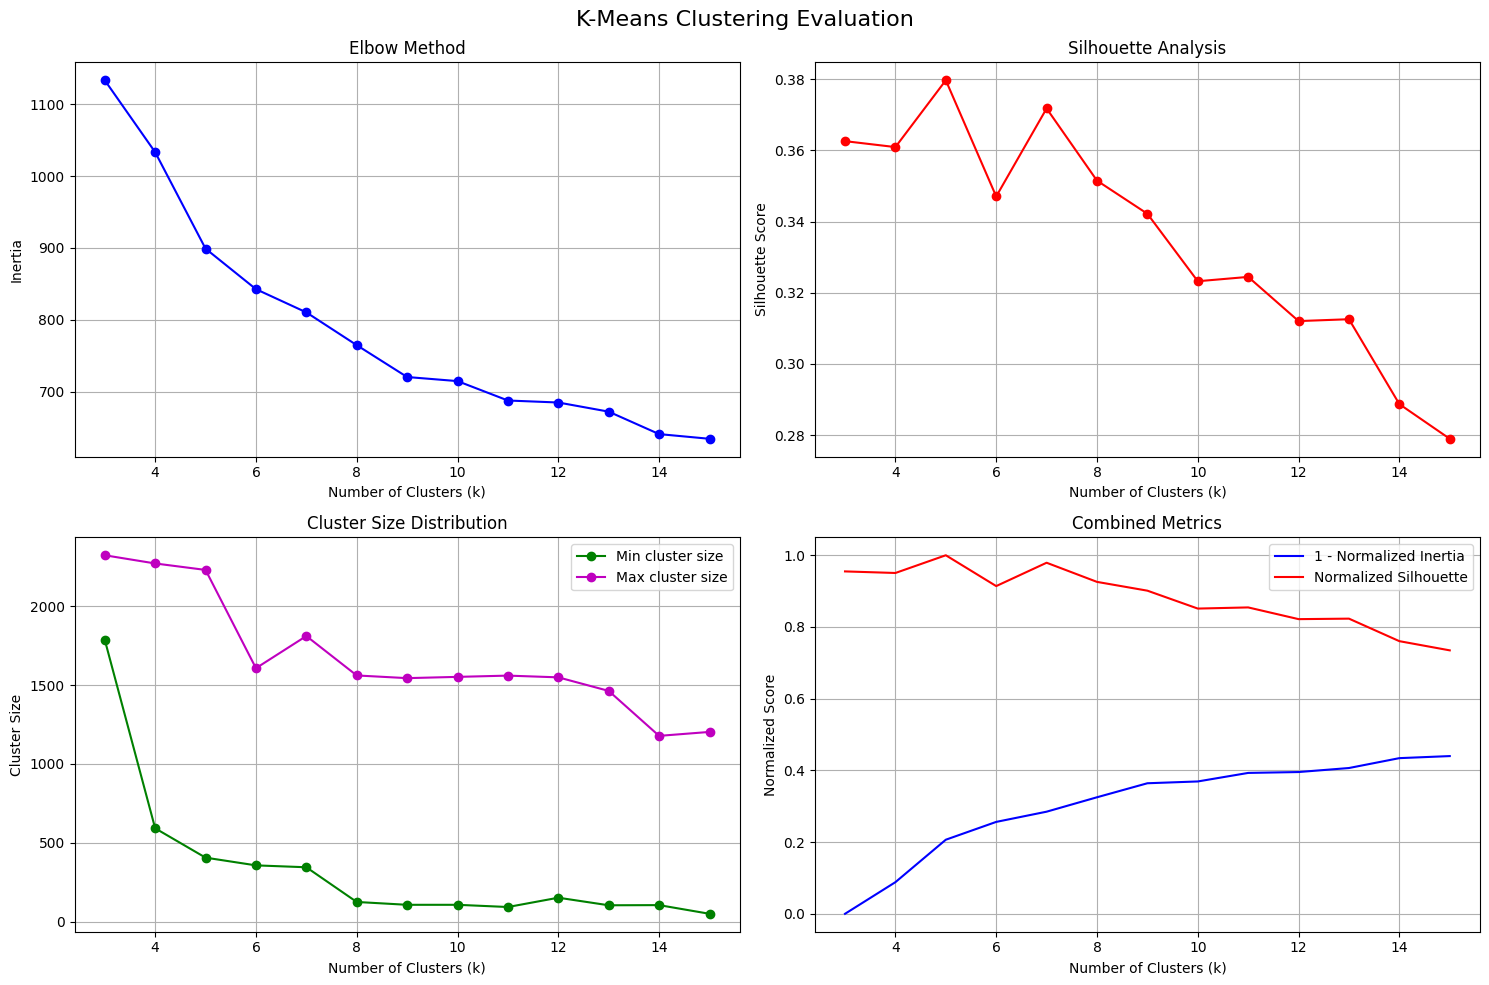


Optimal k based on silhouette score: 5
Best silhouette score: 0.3797


In [11]:
# Plot K-Means evaluation results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('K-Means Clustering Evaluation', fontsize=16)

# Extract data for plotting
k_values = [r['k'] for r in kmeans_results]
inertias = [r['inertia'] for r in kmeans_results]
silhouette_scores = [r['silhouette_score'] for r in kmeans_results]
min_cluster_sizes = [r['min_cluster_size'] for r in kmeans_results]
max_cluster_sizes = [r['max_cluster_size'] for r in kmeans_results]

# Elbow plot
axes[0, 0].plot(k_values, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# Silhouette score plot
axes[0, 1].plot(k_values, silhouette_scores, 'ro-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Analysis')
axes[0, 1].grid(True)

# Cluster size distribution
axes[1, 0].plot(k_values, min_cluster_sizes, 'go-', label='Min cluster size')
axes[1, 0].plot(k_values, max_cluster_sizes, 'mo-', label='Max cluster size')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Cluster Size')
axes[1, 0].set_title('Cluster Size Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Combined metrics (normalized)
norm_inertias = np.array(inertias) / max(inertias)
norm_silhouettes = np.array(silhouette_scores) / max(silhouette_scores)
axes[1, 1].plot(k_values, 1 - norm_inertias, 'b-', label='1 - Normalized Inertia')
axes[1, 1].plot(k_values, norm_silhouettes, 'r-', label='Normalized Silhouette')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Normalized Score')
axes[1, 1].set_title('Combined Metrics')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/kmeans_evaluation.png", dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k based on silhouette score
best_silhouette_idx = np.argmax(silhouette_scores)
optimal_k = k_values[best_silhouette_idx]
print(f"\nOptimal k based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {silhouette_scores[best_silhouette_idx]:.4f}")

In [12]:
# Perform final K-Means clustering with optimal k
print(f"\nPerforming final K-Means clustering with k={optimal_k}...")

final_kmeans = MiniBatchKMeans(
    n_clusters=optimal_k,
    random_state=RANDOM_STATE,
    batch_size=100,
    n_init=20  # More initializations for final model
)

cluster_labels = final_kmeans.fit_predict(features_for_clustering)

# Add cluster labels to image files
for i, img_file in enumerate(image_files):
    img_file['cluster'] = int(cluster_labels[i])

# Analyze cluster composition
print(f"\nCluster Analysis:")
cluster_stats = defaultdict(lambda: defaultdict(int))

for img_file in image_files:
    cluster = img_file['cluster']
    tenant = img_file['tenant']
    cluster_stats[cluster]['total'] += 1
    cluster_stats[cluster][tenant] += 1

for cluster_id in sorted(cluster_stats.keys()):
    stats = cluster_stats[cluster_id]
    total = stats['total']
    print(f"\nCluster {cluster_id}: {total} images")
    
    # Show tenant distribution in this cluster
    tenant_counts = {k: v for k, v in stats.items() if k != 'total'}
    for tenant, count in sorted(tenant_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total) * 100
        print(f"  {tenant}: {count} ({percentage:.1f}%)")


Performing final K-Means clustering with k=5...

Cluster Analysis:

Cluster 0: 1604 images
  bvb: 746 (46.5%)
  vbz: 390 (24.3%)
  ava: 348 (21.7%)
  gvb: 72 (4.5%)
  retm: 48 (3.0%)

Cluster 1: 2289 images
  bernmobil: 671 (29.3%)
  gvb: 590 (25.8%)
  gent: 472 (20.6%)
  vbz: 348 (15.2%)
  cts: 157 (6.9%)
  retm: 24 (1.0%)
  ava: 14 (0.6%)
  bvb: 13 (0.6%)

Cluster 2: 411 images
  cts: 257 (62.5%)
  gent: 100 (24.3%)
  gvb: 40 (9.7%)
  bernmobil: 13 (3.2%)
  retm: 1 (0.2%)

Cluster 3: 1198 images
  retm: 704 (58.8%)
  ava: 398 (33.2%)
  gvb: 45 (3.8%)
  bernmobil: 15 (1.3%)
  gent: 13 (1.1%)
  cts: 13 (1.1%)
  vbz: 10 (0.8%)

Cluster 4: 587 images
  cts: 321 (54.7%)
  gent: 159 (27.1%)
  bernmobil: 51 (8.7%)
  gvb: 38 (6.5%)
  vbz: 13 (2.2%)
  retm: 5 (0.9%)


CLUSTER EXAMPLES


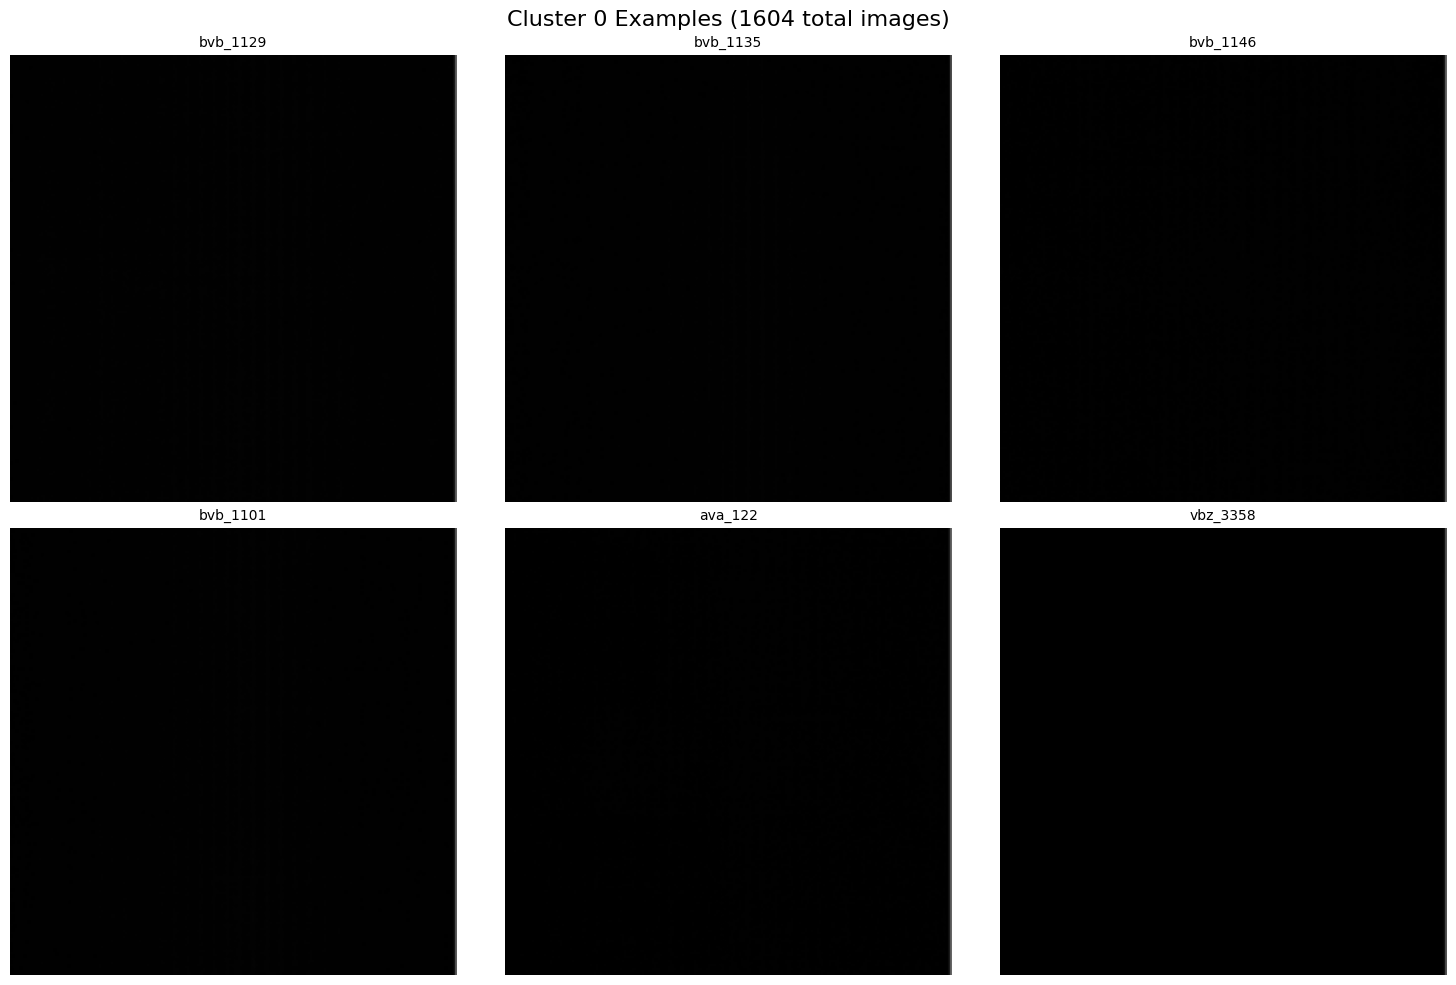

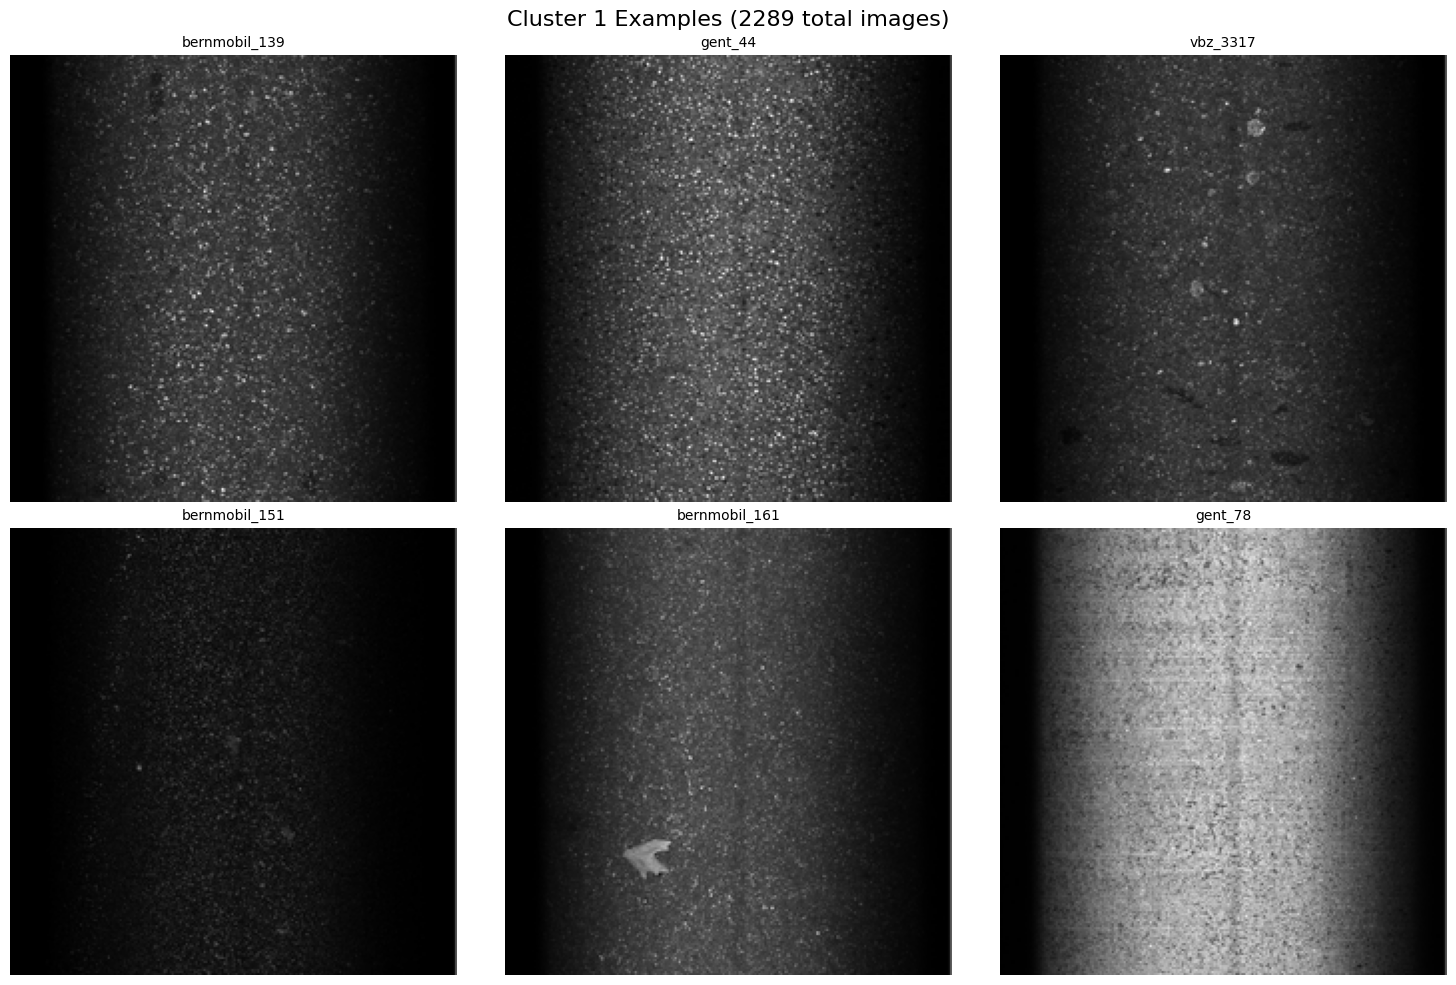

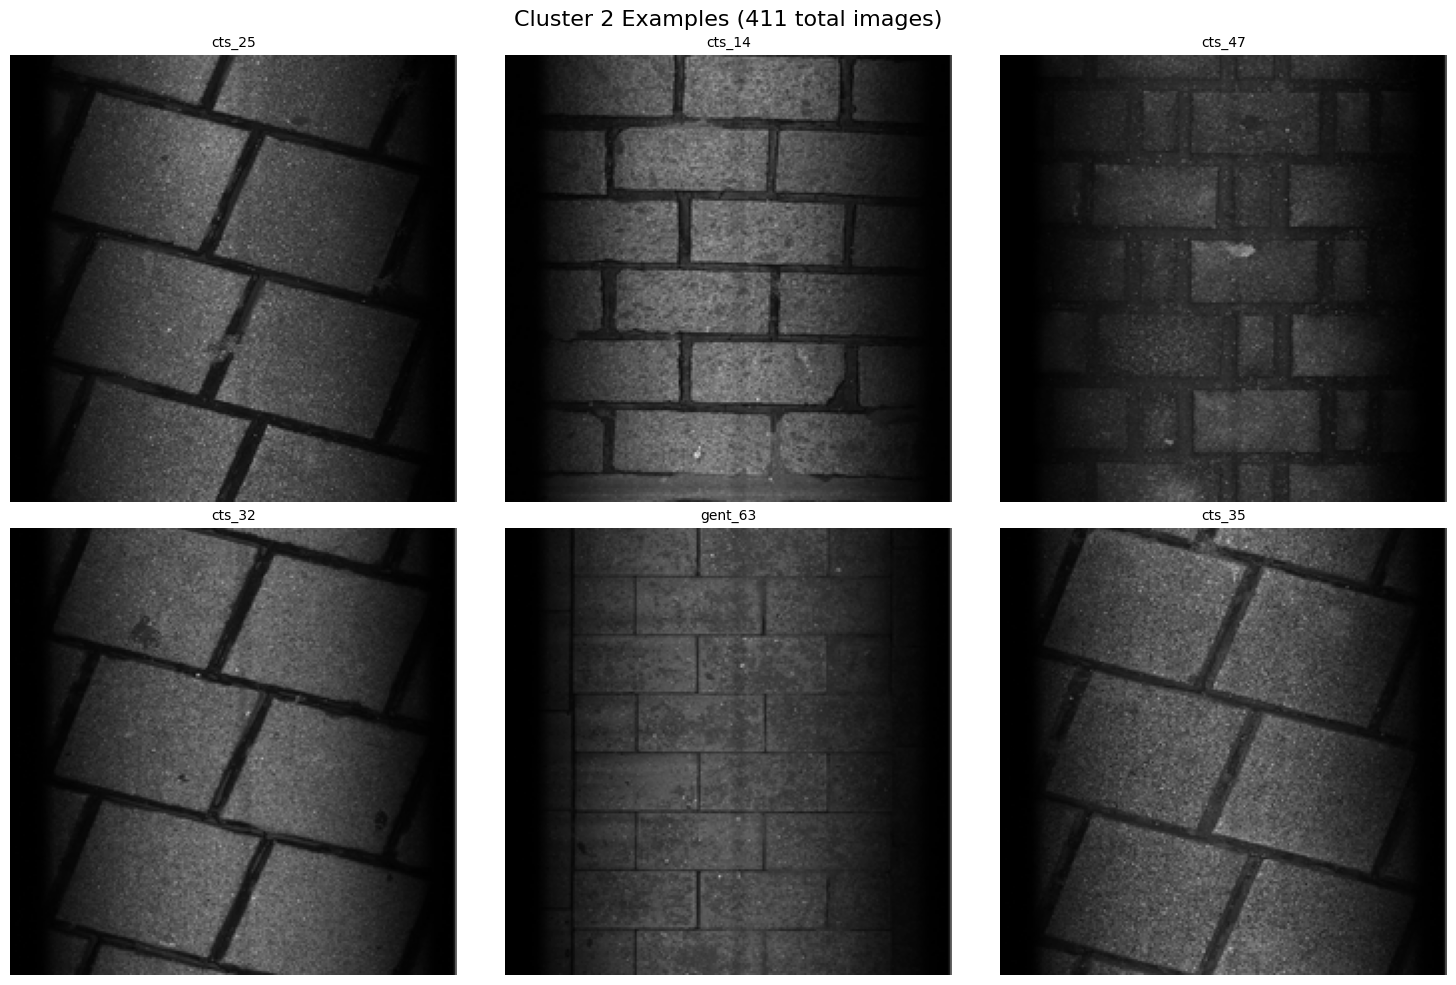

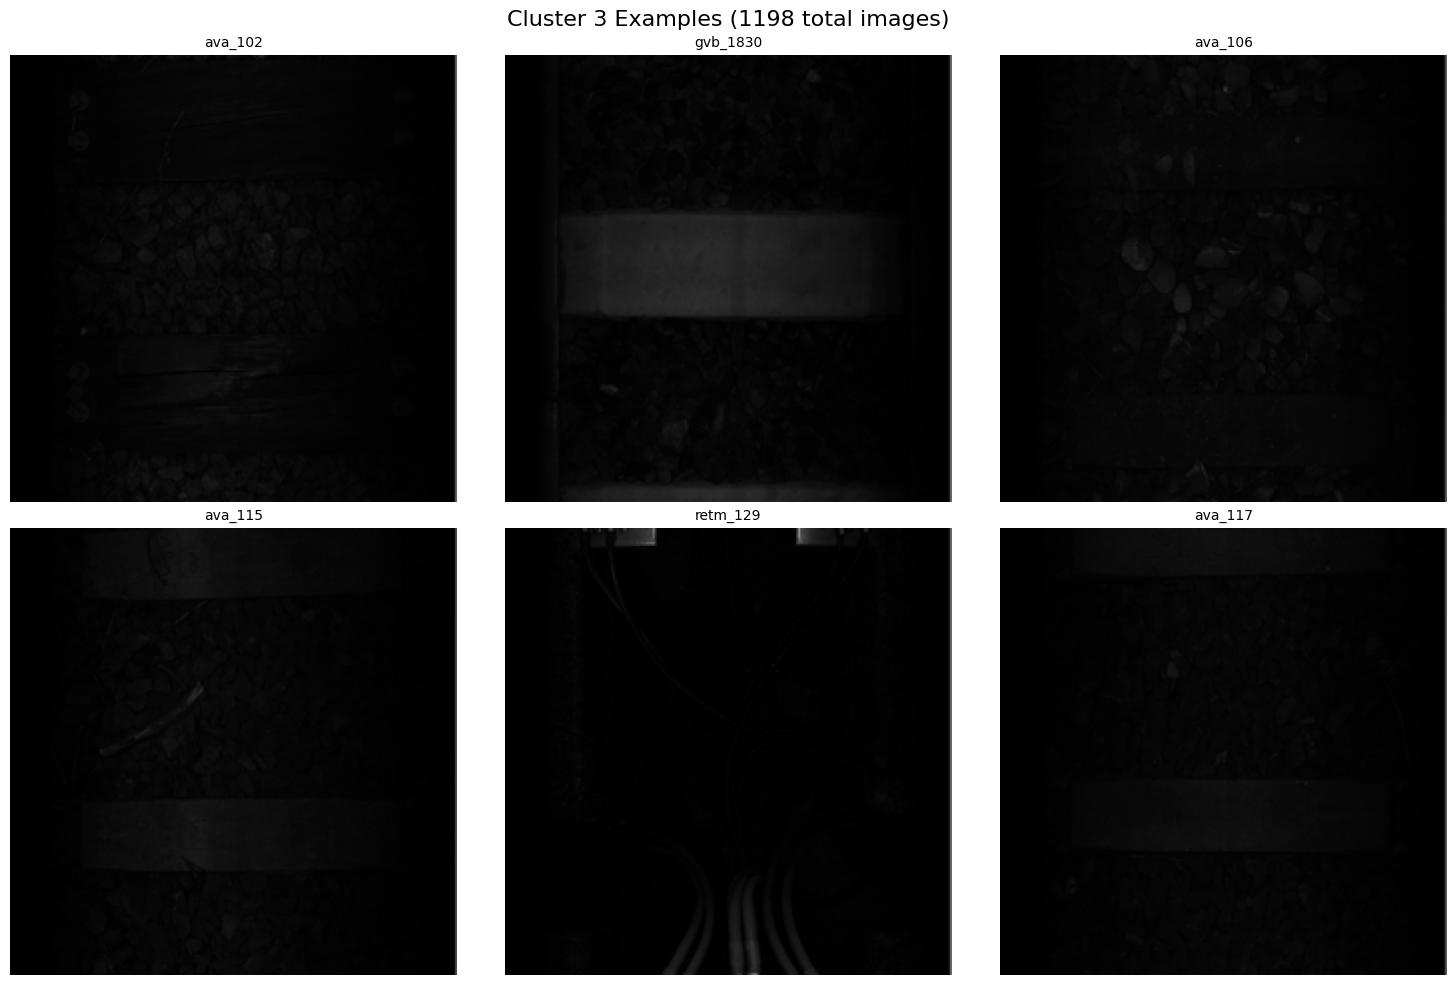

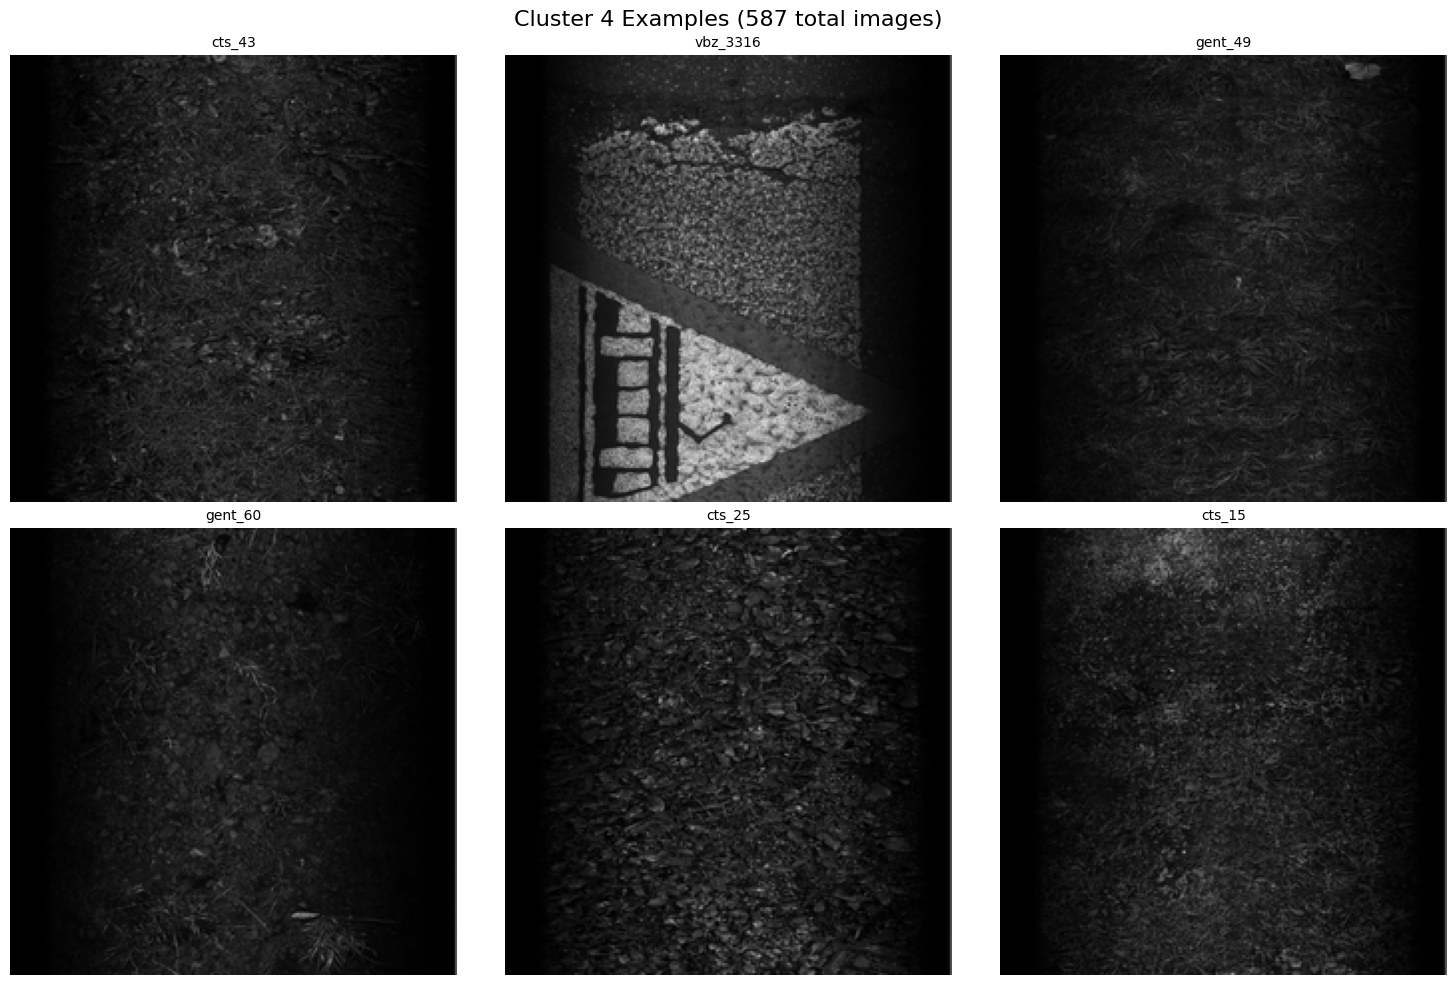

In [13]:
def display_cluster_examples(image_files, cluster_id, n_examples=6):
    """Display example images from a specific cluster."""
    cluster_images = [img for img in image_files if img['cluster'] == cluster_id]
    
    if not cluster_images:
        print(f"No images found for cluster {cluster_id}")
        return
    
    # Randomly sample examples
    examples = np.random.choice(cluster_images, min(n_examples, len(cluster_images)), replace=False)
    
    # Create subplot
    cols = 3
    rows = (len(examples) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Cluster {cluster_id} Examples ({len(cluster_images)} total images)', fontsize=16)
    
    for i, img_info in enumerate(examples):
        row = i // cols
        col = i % cols
        
        # Load and display image
        try:
            img = Image.open(img_info['filepath'])
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"{img_info['tenant']}_{img_info['sid']}", fontsize=10)
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f"Error loading\n{img_info['filename']}", 
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(len(examples), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_PATH}/cluster_{cluster_id}_examples.png", dpi=300, bbox_inches='tight')
    plt.show()

# Display examples for each cluster
print("=" * 80)
print("CLUSTER EXAMPLES")
print("=" * 80)

for cluster_id in sorted(set(cluster_labels)):
    display_cluster_examples(image_files, cluster_id)

In [14]:
# DBSCAN Clustering
print("=" * 80)
print("DBSCAN CLUSTERING")
print("=" * 80)

# Use PCA features for DBSCAN (better performance in lower dimensions)
print("Applying DBSCAN on PCA-reduced features...")

# Try different eps values
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples = 5

dbscan_results = []

for eps in eps_values:
    print(f"\nTesting DBSCAN with eps={eps}, min_samples={min_samples}...")
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(features_pca)
    
    # Count clusters and noise points
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    # Calculate silhouette score (only if we have more than 1 cluster)
    if n_clusters > 1:
        # Filter out noise points for silhouette calculation
        mask = dbscan_labels != -1
        if mask.sum() > 1:  # Need at least 2 points
            silhouette_avg = silhouette_score(features_pca[mask], dbscan_labels[mask])
        else:
            silhouette_avg = -1
    else:
        silhouette_avg = -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette_score': silhouette_avg,
        'labels': dbscan_labels
    })
    
    print(f"  Clusters: {n_clusters}, Noise points: {n_noise}, Silhouette: {silhouette_avg:.4f}")

# Select best DBSCAN result
valid_dbscan = [r for r in dbscan_results if r['silhouette_score'] > 0]
if valid_dbscan:
    best_dbscan = max(valid_dbscan, key=lambda x: x['silhouette_score'])
    print(f"\nBest DBSCAN: eps={best_dbscan['eps']}, {best_dbscan['n_clusters']} clusters, {best_dbscan['n_noise']} noise points")
else:
    print("\nNo valid DBSCAN results found. Consider adjusting parameters.")
    best_dbscan = dbscan_results[0]  # Use first result as fallback

DBSCAN CLUSTERING
Applying DBSCAN on PCA-reduced features...

Testing DBSCAN with eps=0.3, min_samples=5...
  Clusters: 11, Noise points: 420, Silhouette: -0.0312

Testing DBSCAN with eps=0.5, min_samples=5...
  Clusters: 1, Noise points: 3, Silhouette: -1.0000

Testing DBSCAN with eps=0.7, min_samples=5...
  Clusters: 1, Noise points: 0, Silhouette: -1.0000

Testing DBSCAN with eps=1.0, min_samples=5...
  Clusters: 1, Noise points: 0, Silhouette: -1.0000

Testing DBSCAN with eps=1.5, min_samples=5...
  Clusters: 1, Noise points: 0, Silhouette: -1.0000

No valid DBSCAN results found. Consider adjusting parameters.


CLUSTER VISUALIZATION WITH t-SNE
Computing t-SNE embedding...


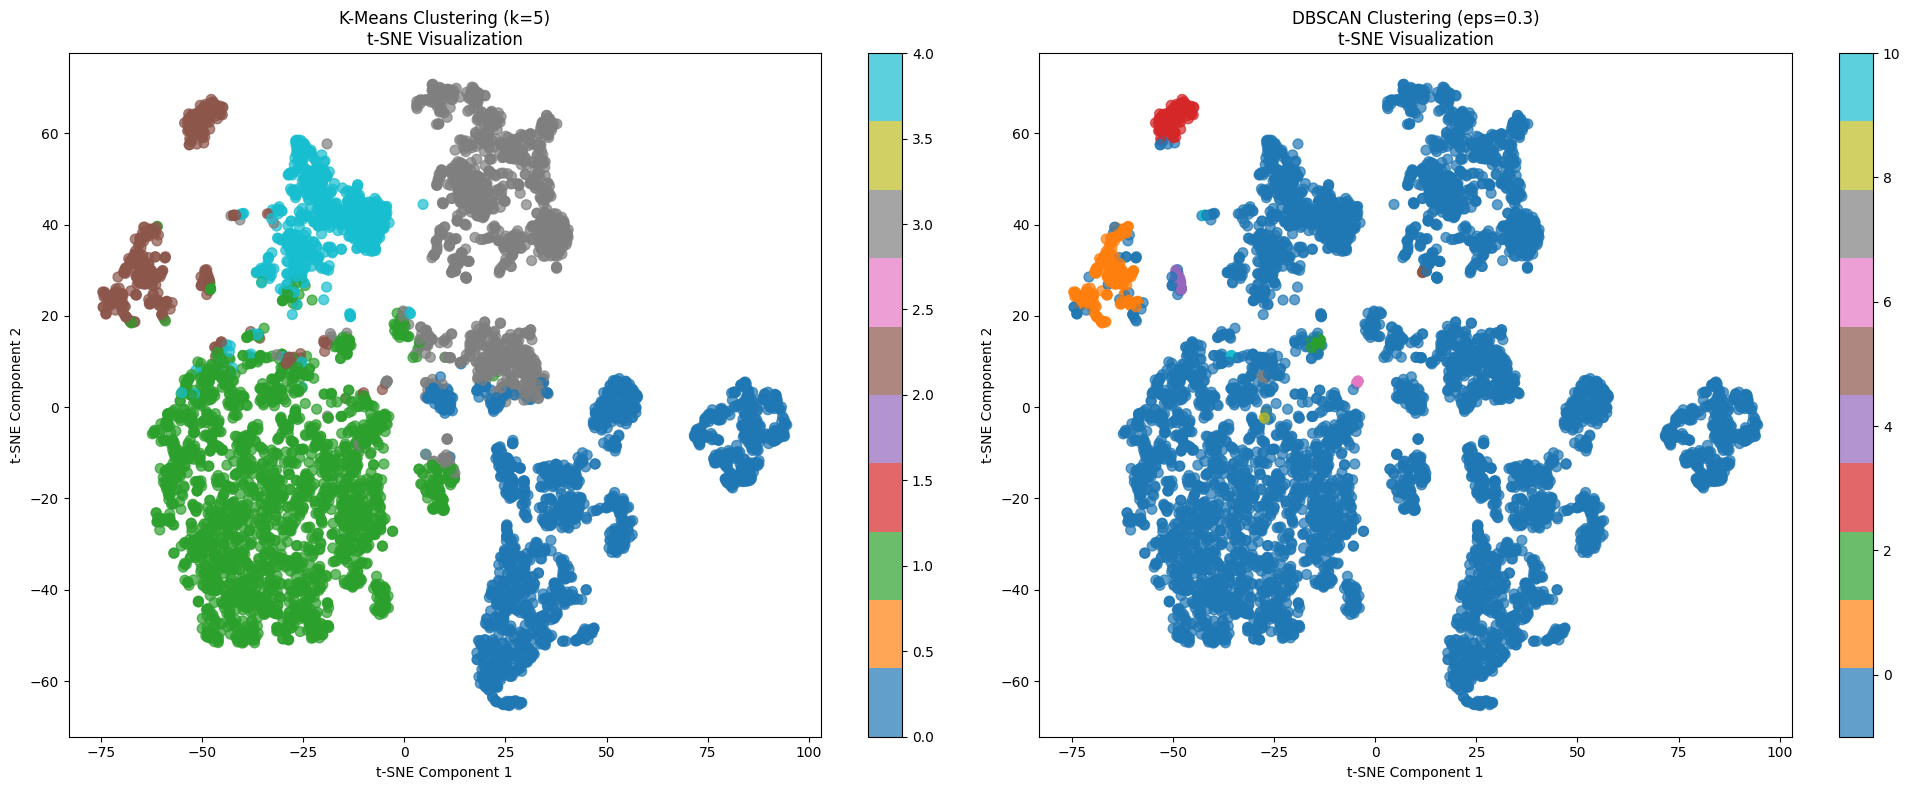

In [15]:
# Visualize clustering results with t-SNE
print("=" * 80)
print("CLUSTER VISUALIZATION WITH t-SNE")
print("=" * 80)

print("Computing t-SNE embedding...")
# Use PCA features for t-SNE (faster and often better results)
tsne = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    perplexity=min(30, len(features_pca) - 1),
    max_iter=1000
)

tsne_features = tsne.fit_transform(features_pca)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot K-Means results
scatter1 = axes[0].scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    c=cluster_labels,
    cmap='tab10',
    alpha=0.7,
    s=50
)
axes[0].set_title(f'K-Means Clustering (k={optimal_k})\nt-SNE Visualization')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter1, ax=axes[0])

# Plot DBSCAN results
scatter2 = axes[1].scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    c=best_dbscan['labels'],
    cmap='tab10',
    alpha=0.7,
    s=50
)
axes[1].set_title(f'DBSCAN Clustering (eps={best_dbscan["eps"]})\nt-SNE Visualization')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/clustering_tsne_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def create_cluster_directories(base_path, method_name, cluster_labels, dbscan_labels=None):
    """Create directory structure for clustered images."""
    method_path = Path(base_path) / method_name
    method_path.mkdir(parents=True, exist_ok=True)
    
    if method_name == 'kmeans':
        unique_clusters = sorted(set(cluster_labels))
    else:  # dbscan
        unique_clusters = sorted(set(dbscan_labels))
        # Handle noise points (-1) separately
        if -1 in unique_clusters:
            unique_clusters = [c for c in unique_clusters if c != -1] + [-1]
    
    cluster_dirs = {}
    for cluster_id in unique_clusters:
        if cluster_id == -1:
            cluster_dir = method_path / 'noise'
        else:
            cluster_dir = method_path / f'cluster_{cluster_id}'
        cluster_dir.mkdir(exist_ok=True)
        cluster_dirs[cluster_id] = cluster_dir
    
    return cluster_dirs

def copy_images_to_clusters(image_files, cluster_dirs, cluster_labels, method_name='kmeans', dbscan_labels=None):
    """Copy images to their respective cluster directories."""
    print(f"\nCopying images to {method_name.upper()} cluster directories...")
    
    if method_name == 'kmeans':
        labels_to_use = cluster_labels
    else:  # dbscan
        labels_to_use = dbscan_labels
    
    copied_count = 0
    error_count = 0
    
    for i, img_file in enumerate(image_files):
        try:
            cluster_id = labels_to_use[i]
            source_path = Path(img_file['filepath'])
            target_dir = cluster_dirs[cluster_id]
            target_path = target_dir / source_path.name
            
            # Copy file if it doesn't exist or is different
            if not target_path.exists() or target_path.stat().st_size != source_path.stat().st_size:
                shutil.copy2(source_path, target_path)
                copied_count += 1
            
        except Exception as e:
            print(f"Error copying {img_file['filename']}: {e}")
            error_count += 1
    
    print(f"Successfully copied {copied_count} images")
    if error_count > 0:
        print(f"Errors: {error_count}")
    
    return copied_count, error_count

def save_cluster_metadata(cluster_dirs, image_files, cluster_labels, method_name='kmeans', dbscan_labels=None):
    """Save metadata for each cluster."""
    print(f"\nSaving {method_name.upper()} cluster metadata...")
    
    if method_name == 'kmeans':
        labels_to_use = cluster_labels
    else:  # dbscan
        labels_to_use = dbscan_labels
    
    for cluster_id, cluster_dir in cluster_dirs.items():
        # Get images for this cluster
        cluster_images = []
        for i, img_file in enumerate(image_files):
            if int(labels_to_use[i]) == cluster_id:  # Convert numpy int32 to Python int
                cluster_images.append({
                    'filename': img_file['filename'],
                    'tenant': img_file['tenant'],
                    'sid': img_file['sid'],
                    'original_name': img_file['original_name']
                })
        
        # Calculate statistics
        tenant_counts = Counter([img['tenant'] for img in cluster_images])
        
        metadata = {
            'cluster_id': int(cluster_id) if isinstance(cluster_id, (np.integer, np.int32, np.int64)) else cluster_id,  # Ensure cluster_id is JSON serializable
            'method': method_name,
            'total_images': len(cluster_images),
            'tenant_distribution': dict(tenant_counts),
            'images': cluster_images
        }
        
        # Save metadata
        metadata_file = cluster_dir / 'cluster_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
    
    print(f"Metadata saved for {len(cluster_dirs)} clusters")

In [17]:
# Save K-Means clustering results to directories
print("=" * 80)
print("SAVING K-MEANS CLUSTERS TO DIRECTORIES")
print("=" * 80)

# Create base directory for clustered images
CLUSTERS_PATH = "./results/clustered_images"
Path(CLUSTERS_PATH).mkdir(parents=True, exist_ok=True)

# Create K-Means cluster directories
kmeans_dirs = create_cluster_directories(CLUSTERS_PATH, 'kmeans', cluster_labels)

print(f"Created K-Means cluster directories:")
for cluster_id, cluster_dir in sorted(kmeans_dirs.items()):
    cluster_size = sum(1 for label in cluster_labels if label == cluster_id)
    print(f"  {cluster_dir.name}: {cluster_size} images")

# Copy images to K-Means clusters
kmeans_copied, kmeans_errors = copy_images_to_clusters(
    image_files, kmeans_dirs, cluster_labels, 'kmeans'
)

# Save K-Means cluster metadata
save_cluster_metadata(kmeans_dirs, image_files, cluster_labels, 'kmeans')

print(f"\nK-Means clustering results saved to: {Path(CLUSTERS_PATH) / 'kmeans'}")

SAVING K-MEANS CLUSTERS TO DIRECTORIES
Created K-Means cluster directories:
  cluster_0: 1604 images
  cluster_1: 2289 images
  cluster_2: 411 images
  cluster_3: 1198 images
  cluster_4: 587 images

Copying images to KMEANS cluster directories...
Successfully copied 6089 images

Saving KMEANS cluster metadata...
Metadata saved for 5 clusters

K-Means clustering results saved to: results/clustered_images/kmeans


In [18]:
# Save DBSCAN clustering results to directories
print("=" * 80)
print("SAVING DBSCAN CLUSTERS TO DIRECTORIES")
print("=" * 80)

# Add DBSCAN cluster labels to image files for consistency
dbscan_labels = best_dbscan['labels']
for i, img_file in enumerate(image_files):
    img_file['dbscan_cluster'] = int(dbscan_labels[i])

# Create DBSCAN cluster directories
dbscan_dirs = create_cluster_directories(CLUSTERS_PATH, 'dbscan', None, dbscan_labels)

print(f"Created DBSCAN cluster directories:")
for cluster_id, cluster_dir in sorted(dbscan_dirs.items()):
    cluster_size = sum(1 for label in dbscan_labels if label == cluster_id)
    if cluster_id == -1:
        print(f"  {cluster_dir.name} (noise): {cluster_size} images")
    else:
        print(f"  {cluster_dir.name}: {cluster_size} images")

# Copy images to DBSCAN clusters
dbscan_copied, dbscan_errors = copy_images_to_clusters(
    image_files, dbscan_dirs, None, 'dbscan', dbscan_labels
)

# Save DBSCAN cluster metadata
save_cluster_metadata(dbscan_dirs, image_files, None, 'dbscan', dbscan_labels)

print(f"\nDBSCAN clustering results saved to: {Path(CLUSTERS_PATH) / 'dbscan'}")

SAVING DBSCAN CLUSTERS TO DIRECTORIES
Created DBSCAN cluster directories:
  noise (noise): 420 images
  cluster_0: 5263 images
  cluster_1: 213 images
  cluster_2: 22 images
  cluster_3: 103 images
  cluster_4: 29 images
  cluster_5: 7 images
  cluster_6: 8 images
  cluster_7: 8 images
  cluster_8: 6 images
  cluster_9: 5 images
  cluster_10: 5 images

Copying images to DBSCAN cluster directories...
Successfully copied 6089 images

Saving DBSCAN cluster metadata...
Metadata saved for 12 clusters

DBSCAN clustering results saved to: results/clustered_images/dbscan


In [19]:
# Generate summary report for clustered images
print("=" * 80)
print("CLUSTER ORGANIZATION SUMMARY")
print("=" * 80)

# Create comprehensive summary
cluster_summary = {
    'dataset_info': {
        'source_dataset': str(Path(DATASET_PATH).resolve()),
        'total_images_processed': len(image_files),
        'clustering_date': time.strftime('%Y-%m-%d %H:%M:%S')
    },
    'kmeans_clustering': {
        'method': 'K-Means (MiniBatch)',
        'optimal_k': optimal_k,
        'silhouette_score': float(silhouette_scores[best_silhouette_idx]),
        'images_copied': kmeans_copied,
        'copy_errors': kmeans_errors,
        'cluster_distribution': {
            str(cluster_id): int(count) for cluster_id, count in Counter(cluster_labels).items()
        }
    },
    'dbscan_clustering': {
        'method': 'DBSCAN',
        'eps': best_dbscan['eps'],
        'min_samples': min_samples,
        'n_clusters': best_dbscan['n_clusters'],
        'n_noise': best_dbscan['n_noise'],
        'silhouette_score': float(best_dbscan['silhouette_score']),
        'images_copied': dbscan_copied,
        'copy_errors': dbscan_errors,
        'cluster_distribution': {
            str(cluster_id): int(count) for cluster_id, count in Counter(dbscan_labels).items()
        }
    },
    'directory_structure': {
        'base_path': str(Path(CLUSTERS_PATH).resolve()),
        'kmeans_path': str(Path(CLUSTERS_PATH, 'kmeans').resolve()),
        'dbscan_path': str(Path(CLUSTERS_PATH, 'dbscan').resolve())
    }
}

# Save cluster summary
summary_file = Path(CLUSTERS_PATH) / 'clustering_summary.json'
with open(summary_file, 'w') as f:
    json.dump(cluster_summary, f, indent=2)

print(f"Cluster organization completed successfully!")
print(f"\nSummary:")
print(f"- Total images processed: {len(image_files)}")
print(f"- K-Means clusters created: {len(kmeans_dirs)}")
print(f"- DBSCAN clusters created: {len(dbscan_dirs)}")
print(f"- Images copied (K-Means): {kmeans_copied}")
print(f"- Images copied (DBSCAN): {dbscan_copied}")

print(f"\nDirectory structure created:")
print(f"{CLUSTERS_PATH}/")
print(f"├── kmeans/")
for cluster_id in sorted(set(cluster_labels)):
    cluster_size = sum(1 for label in cluster_labels if label == cluster_id)
    print(f"│   ├── cluster_{cluster_id}/ ({cluster_size} images)")
print(f"└── dbscan/")
for cluster_id in sorted(set(dbscan_labels)):
    cluster_size = sum(1 for label in dbscan_labels if label == cluster_id)
    if cluster_id == -1:
        print(f"    ├── noise/ ({cluster_size} images)")
    else:
        print(f"    ├── cluster_{cluster_id}/ ({cluster_size} images)")

print(f"\nFiles saved:")
print(f"- Cluster summary: {summary_file}")
print(f"- Individual cluster metadata: cluster_metadata.json in each cluster directory")
print(f"- Analysis results: {RESULTS_PATH}/")

CLUSTER ORGANIZATION SUMMARY
Cluster organization completed successfully!

Summary:
- Total images processed: 6089
- K-Means clusters created: 5
- DBSCAN clusters created: 12
- Images copied (K-Means): 6089
- Images copied (DBSCAN): 6089

Directory structure created:
./results/clustered_images/
├── kmeans/
│   ├── cluster_0/ (1604 images)
│   ├── cluster_1/ (2289 images)
│   ├── cluster_2/ (411 images)
│   ├── cluster_3/ (1198 images)
│   ├── cluster_4/ (587 images)
└── dbscan/
    ├── noise/ (420 images)
    ├── cluster_0/ (5263 images)
    ├── cluster_1/ (213 images)
    ├── cluster_2/ (22 images)
    ├── cluster_3/ (103 images)
    ├── cluster_4/ (29 images)
    ├── cluster_5/ (7 images)
    ├── cluster_6/ (8 images)
    ├── cluster_7/ (8 images)
    ├── cluster_8/ (6 images)
    ├── cluster_9/ (5 images)
    ├── cluster_10/ (5 images)

Files saved:
- Cluster summary: results/clustered_images/clustering_summary.json
- Individual cluster metadata: cluster_metadata.json in each cluste

TENANT DISTRIBUTION ANALYSIS


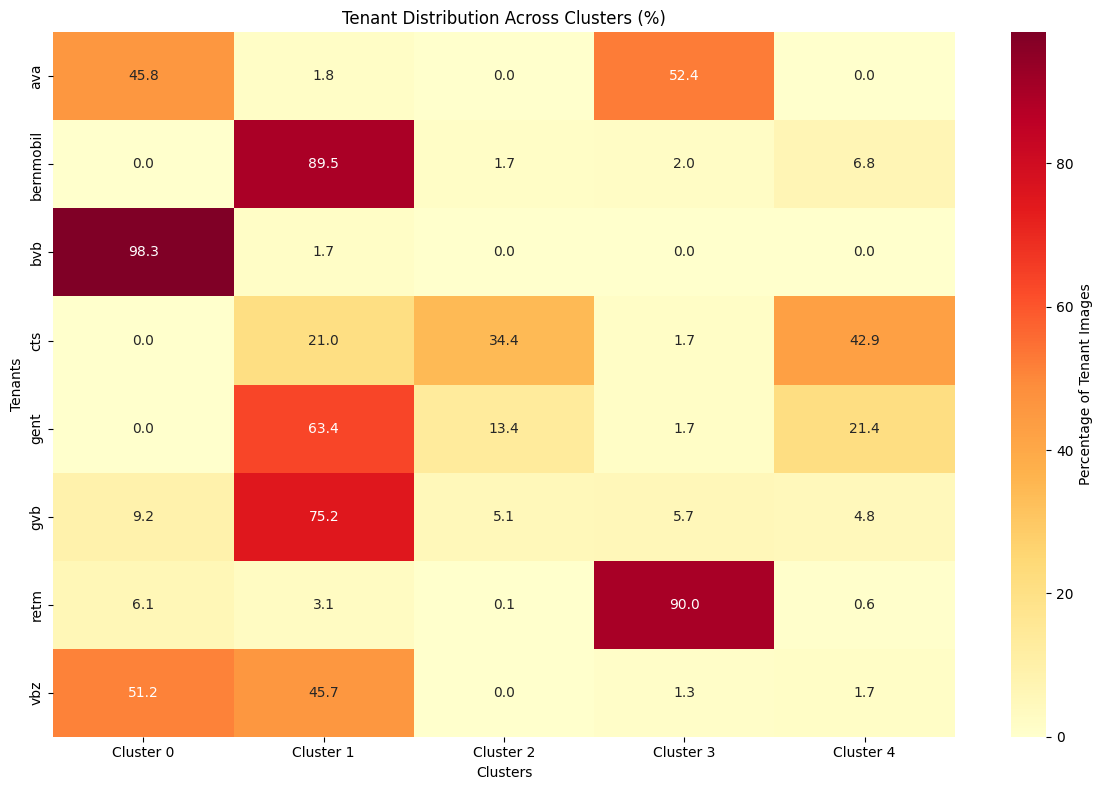


Detailed Tenant-Cluster Distribution:

ava (760 images):
  Cluster 0: 348 images (45.8%)
  Cluster 1: 14 images (1.8%)
  Cluster 3: 398 images (52.4%)

bernmobil (750 images):
  Cluster 1: 671 images (89.5%)
  Cluster 2: 13 images (1.7%)
  Cluster 3: 15 images (2.0%)
  Cluster 4: 51 images (6.8%)

bvb (759 images):
  Cluster 0: 746 images (98.3%)
  Cluster 1: 13 images (1.7%)

cts (748 images):
  Cluster 1: 157 images (21.0%)
  Cluster 2: 257 images (34.4%)
  Cluster 3: 13 images (1.7%)
  Cluster 4: 321 images (42.9%)

gent (744 images):
  Cluster 1: 472 images (63.4%)
  Cluster 2: 100 images (13.4%)
  Cluster 3: 13 images (1.7%)
  Cluster 4: 159 images (21.4%)

gvb (785 images):
  Cluster 0: 72 images (9.2%)
  Cluster 1: 590 images (75.2%)
  Cluster 2: 40 images (5.1%)
  Cluster 3: 45 images (5.7%)
  Cluster 4: 38 images (4.8%)

retm (782 images):
  Cluster 0: 48 images (6.1%)
  Cluster 1: 24 images (3.1%)
  Cluster 2: 1 images (0.1%)
  Cluster 3: 704 images (90.0%)
  Cluster 4: 5 im

In [20]:
# Analyze tenant distribution across clusters
print("=" * 80)
print("TENANT DISTRIBUTION ANALYSIS")
print("=" * 80)

# Create tenant-cluster matrix
tenant_cluster_matrix = defaultdict(lambda: defaultdict(int))
total_by_tenant = defaultdict(int)

for img_file in image_files:
    tenant = img_file['tenant']
    cluster = img_file['cluster']
    tenant_cluster_matrix[tenant][cluster] += 1
    total_by_tenant[tenant] += 1

# Convert to DataFrame for easier visualization
tenants = sorted(total_by_tenant.keys())
clusters = sorted(set(cluster_labels))

matrix_data = []
for tenant in tenants:
    row = []
    for cluster in clusters:
        count = tenant_cluster_matrix[tenant][cluster]
        percentage = (count / total_by_tenant[tenant]) * 100
        row.append(percentage)
    matrix_data.append(row)

# Create heatmap
plt.figure(figsize=(12, 8))
heatmap_data = np.array(matrix_data)
sns.heatmap(
    heatmap_data,
    xticklabels=[f'Cluster {c}' for c in clusters],
    yticklabels=tenants,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Percentage of Tenant Images'}
)
plt.title('Tenant Distribution Across Clusters (%)')
plt.xlabel('Clusters')
plt.ylabel('Tenants')
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/tenant_cluster_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\nDetailed Tenant-Cluster Distribution:")
for tenant in tenants:
    print(f"\n{tenant} ({total_by_tenant[tenant]} images):")
    for cluster in clusters:
        count = tenant_cluster_matrix[tenant][cluster]
        percentage = (count / total_by_tenant[tenant]) * 100
        if count > 0:
            print(f"  Cluster {cluster}: {count} images ({percentage:.1f}%)")

In [ ]:
# Generate comprehensive clustering report
print("=" * 80)
print("CLUSTERING ANALYSIS SUMMARY")
print("=" * 80)

# Compile results
clustering_report = {
    'dataset_info': {
        'total_images': int(len(image_files)),
        'feature_dimension': int(FEATURE_DIM),
        'pca_components': int(PCA_COMPONENTS),
        'pca_explained_variance': float(pca.explained_variance_ratio_.sum()),
        'tenant_distribution': {k: int(v) for k, v in tenant_distribution.items()}
    },
    'kmeans_results': {
        'optimal_k': int(optimal_k),
        'silhouette_score': float(silhouette_scores[best_silhouette_idx]),
        'cluster_sizes': {int(k): int(v) for k, v in Counter(cluster_labels).items()},
        'evaluation_results': [
            {
                'k': int(r['k']),
                'inertia': float(r['inertia']),
                'silhouette_score': float(r['silhouette_score'])
            } for r in kmeans_results
        ]
    },
    'dbscan_results': {
        'best_eps': float(best_dbscan['eps']),
        'n_clusters': int(best_dbscan['n_clusters']),
        'n_noise': int(best_dbscan['n_noise']),
        'silhouette_score': float(best_dbscan['silhouette_score'])
    },
    'tenant_cluster_analysis': {
        tenant: {
            'total_images': int(total_by_tenant[tenant]),
            'cluster_distribution': {int(k): int(v) for k, v in tenant_cluster_matrix[tenant].items()}
        } for tenant in tenants
    }
}

# Save results
with open(f"{RESULTS_PATH}/clustering_report.json", 'w') as f:
    json.dump(clustering_report, f, indent=2)

# Print summary
print(f"Analysis completed successfully!")
print(f"\nKey Findings:")
print(f"- Optimal number of clusters (K-Means): {optimal_k}")
print(f"- Best silhouette score: {silhouette_scores[best_silhouette_idx]:.4f}")
print(f"- DBSCAN found {best_dbscan['n_clusters']} clusters with {best_dbscan['n_noise']} noise points")
print(f"- PCA captured {pca.explained_variance_ratio_.sum():.1%} of the variance")

print(f"\nCluster sizes (K-Means):")
cluster_sizes = Counter(cluster_labels)
for cluster_id, size in sorted(cluster_sizes.items()):
    percentage = (size / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {size} images ({percentage:.1f}%)")

print(f"\nResults saved to: {RESULTS_PATH}")
print(f"- Clustering report: clustering_report.json")
print(f"- Visualizations: *.png files")
print(f"- Cluster examples: cluster_*_examples.png")

CLUSTERING ANALYSIS SUMMARY


TypeError: keys must be str, int, float, bool or None, not int32

In [22]:
# Interpretation and next steps
print("=" * 80)
print("INTERPRETATION AND NEXT STEPS")
print("=" * 80)

print("Based on the cluster analysis, consider the following interpretations:")
print()

# Analyze cluster characteristics
print("Cluster Characteristics Analysis:")
for cluster_id in sorted(cluster_sizes.keys()):
    cluster_images = [img for img in image_files if img['cluster'] == cluster_id]
    cluster_tenants = [img['tenant'] for img in cluster_images]
    tenant_counts = Counter(cluster_tenants)
    dominant_tenant = tenant_counts.most_common(1)[0]
    
    print(f"\nCluster {cluster_id} ({len(cluster_images)} images):")
    print(f"  Dominant tenant: {dominant_tenant[0]} ({dominant_tenant[1]}/{len(cluster_images)} images, {dominant_tenant[1]/len(cluster_images)*100:.1f}%)")
    
    if len(tenant_counts) == 1:
        print(f"  Interpretation: Tenant-specific characteristics ({dominant_tenant[0]})")
    elif dominant_tenant[1] / len(cluster_images) > 0.7:
        print(f"  Interpretation: Primarily {dominant_tenant[0]} with some similarities to other tenants")
    else:
        print(f"  Interpretation: Mixed tenant cluster - likely represents common infrastructure features")

print("\nPotential classification tasks based on clustering:")
print("1. Tenant Classification: Classify images by transportation company")
print("2. Infrastructure Type: Distinguish between different track types (e.g., embedded vs. ballasted)")
print("3. Environmental Conditions: Classify by lighting, weather, or time of day")
print("4. Urban vs. Rural: Distinguish between city and countryside rail infrastructure")
print()
print("Recommended next steps:")
print("1. Manually inspect cluster examples to understand what visual features drive the clustering")
print("2. Create labels based on identified patterns (e.g., 'gravel_track', 'asphalt_embedded', etc.)")
print("3. Use these labels to train supervised classifiers")
print("4. Consider data augmentation strategies for underrepresented clusters")
print("5. Evaluate whether clustering captures meaningful domain-specific patterns")

INTERPRETATION AND NEXT STEPS
Based on the cluster analysis, consider the following interpretations:

Cluster Characteristics Analysis:


NameError: name 'cluster_sizes' is not defined